In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [2]:
%%time
opt_parms = { 'ovs': 4096,
             'surf_units': u.micron,
             'ca': 75,
             'ring_width': 3,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m} #1/u.mm}

parent_dir = '/home/jhen/XWCL/code/CACTI/'
data_folder = parent_dir + 'zygo_data/OAP_coated/'
oap_labels =  ('A', 'B', 'C', 'D', 'E', 'F')#, 'G', 'H')
oap=[]

for surface_name in oap_labels:
    n_step = 'OAP {0}'.format(surface_name)
    file_loc=data_folder+'oap{0}_{1}CA'.format(surface_name, opt_parms['ca'])
    # create the object
    opt = psd.surfPSD(surf_name = n_step)
    opt.open_surf(fileloc=file_loc+'_surf.fits', 
                  surf_units = opt_parms['surf_units'])
    opt.open_mask(fileloc=file_loc+'_mask.fits')
    opt.calc_psd(oversamp = opt_parms['ovs'], 
                 kmid_ll=opt_parms['kmid_ll'], 
                 khigh_ll=opt_parms['khigh_ll'])
    print('PSD for {0} complete'.format(n_step))
    # apply DM filter
    
    # Radial profile setup
    opt.calc_psd_radial(ring_width=opt_parms['ring_width'],
                        kmin = opt.k_min)
    print('Radial profile for {0} complete\n'.format(n_step))
    oap.append(opt)

PSD for OAP A complete
Radial profile for OAP A complete

PSD for OAP B complete
Radial profile for OAP B complete

PSD for OAP C complete
Radial profile for OAP C complete

PSD for OAP D complete
Radial profile for OAP D complete

PSD for OAP E complete
Radial profile for OAP E complete

PSD for OAP F complete
Radial profile for OAP F complete

CPU times: user 15min 22s, sys: 5min 50s, total: 21min 13s
Wall time: 21min 3s


The average PSD is calculated by averaging all of the normalized PSDs, then multiplying by the average variance. Get the radial from the average PSD.

In [3]:
%%time
# calculate the average PSD
avg_var = np.mean([obj.var.value for obj in oap])*oap[0].var.unit

# calculate the average psd and get the calculation from there
avg_psd = np.zeros_like(oap[0].psd_cal.value)
for n in range(0, len(oap_labels)):
    avg_psd += oap[n].psd_norm.value
avg_psd /= len(oap_labels)
avg_psd = avg_psd * avg_var.value * oap[0].psd_cal.unit

# now take the radial
avg_psd_k, avg_psd_radial = psd.do_psd_radial(psd_data=avg_psd, delta_k=oap[0].delta_k, 
                                              ring_width=opt_parms['ring_width'], kmin=oap[0].k_min)

CPU times: user 2min 37s, sys: 59.2 s, total: 3min 36s
Wall time: 3min 36s


### Calculate rms: beam diameter, DM correction
RMS values are for surface only. Beam diameter and DM correction do not assume OAP angle adjustment.

In [13]:
# set up along y axis because beam doesn't change shape on this axis
n_act_diam = 25 # y axis
beam_diam = 0.0075*u.m # 7.5mm beam diameter
bw_beam = 1/beam_diam
bw_dm = n_act_diam/(2*beam_diam)

In [16]:
(oap[0].k_min, bw_beam, bw_dm, oap[0].k_max)
# The expectation is that all the values are in ascending order.

(<Quantity 26.39418732 1 / m>,
 <Quantity 133.33333333 1 / m>,
 <Quantity 1666.66666667 1 / m>,
 <Quantity 2982.54316761 1 / m>)

In [42]:
beam_rms = []
dm_rms = []
for j in range(0, len(oap)):
    kmax = oap[j].k_max
    print('optic: {0}'.format(oap[j].surf_name))
    print('RMS (CA): {0:.3f}'.format(oap[j].rms_tot))
    #print('kmin={1:.4f}'.format(beam_diam[j], kmin))
    rms_val = psd.do_psd_rms(psd_data=oap[j].psd_cal, delta_k=oap[j].delta_k, 
                             k_tgt_lim=[bw_beam, kmax], 
                             print_rms=False)
    print('RMS (beam): {0:.3f}'.format(rms_val))
    beam_rms.append(rms_val.value)
    # calculate DM rms
    rms_bmc1k = psd.do_psd_rms(psd_data=oap[j].psd_cal, delta_k=oap[j].delta_k,
                               k_tgt_lim=[bw_dm, kmax], 
                               print_rms=False)
    print('RMS (DM): {0:.3f}'.format(rms_bmc1k))
    dm_rms.append(rms_bmc1k.value)
    print('-----')
# calculate with the average
print('optic: average')
avg_rms = psd.do_psd_rms(psd_data=avg_psd, delta_k=oap[0].delta_k, 
                         k_tgt_lim=(oap[0].k_min, oap[0].k_max), print_rms=False)
print('RMS (CA): {0:.3f}'.format(avg_rms))
avg_beam_rms = psd.do_psd_rms(psd_data=avg_psd, delta_k=oap[0].delta_k, 
                         k_tgt_lim=(bw_beam, oap[0].k_max), print_rms=False)
print('RMS (beam): {0:.3f}'.format(avg_beam_rms))
avg_dm_rms = psd.do_psd_rms(psd_data=avg_psd, delta_k=oap[0].delta_k, 
                         k_tgt_lim=(bw_dm, oap[0].k_max), print_rms=False)
print('RMS (DM): {0:.3f}'.format(avg_dm_rms))

optic: OAP A
RMS (CA): 19.399 nm
RMS (beam): 11.570 nm
RMS (DM): 1.019 nm
-----
optic: OAP B
RMS (CA): 21.405 nm
RMS (beam): 9.805 nm
RMS (DM): 1.301 nm
-----
optic: OAP C
RMS (CA): 21.625 nm
RMS (beam): 14.221 nm
RMS (DM): 1.058 nm
-----
optic: OAP D
RMS (CA): 18.922 nm
RMS (beam): 8.955 nm
RMS (DM): 1.107 nm
-----
optic: OAP E
RMS (CA): 24.995 nm
RMS (beam): 13.908 nm
RMS (DM): 1.264 nm
-----
optic: OAP F
RMS (CA): 24.198 nm
RMS (beam): 10.015 nm
RMS (DM): 1.264 nm
-----
optic: average
RMS (CA): 21.827 nm
RMS (beam): 11.661 nm
RMS (DM): 1.178 nm


## Plotting the PSDs

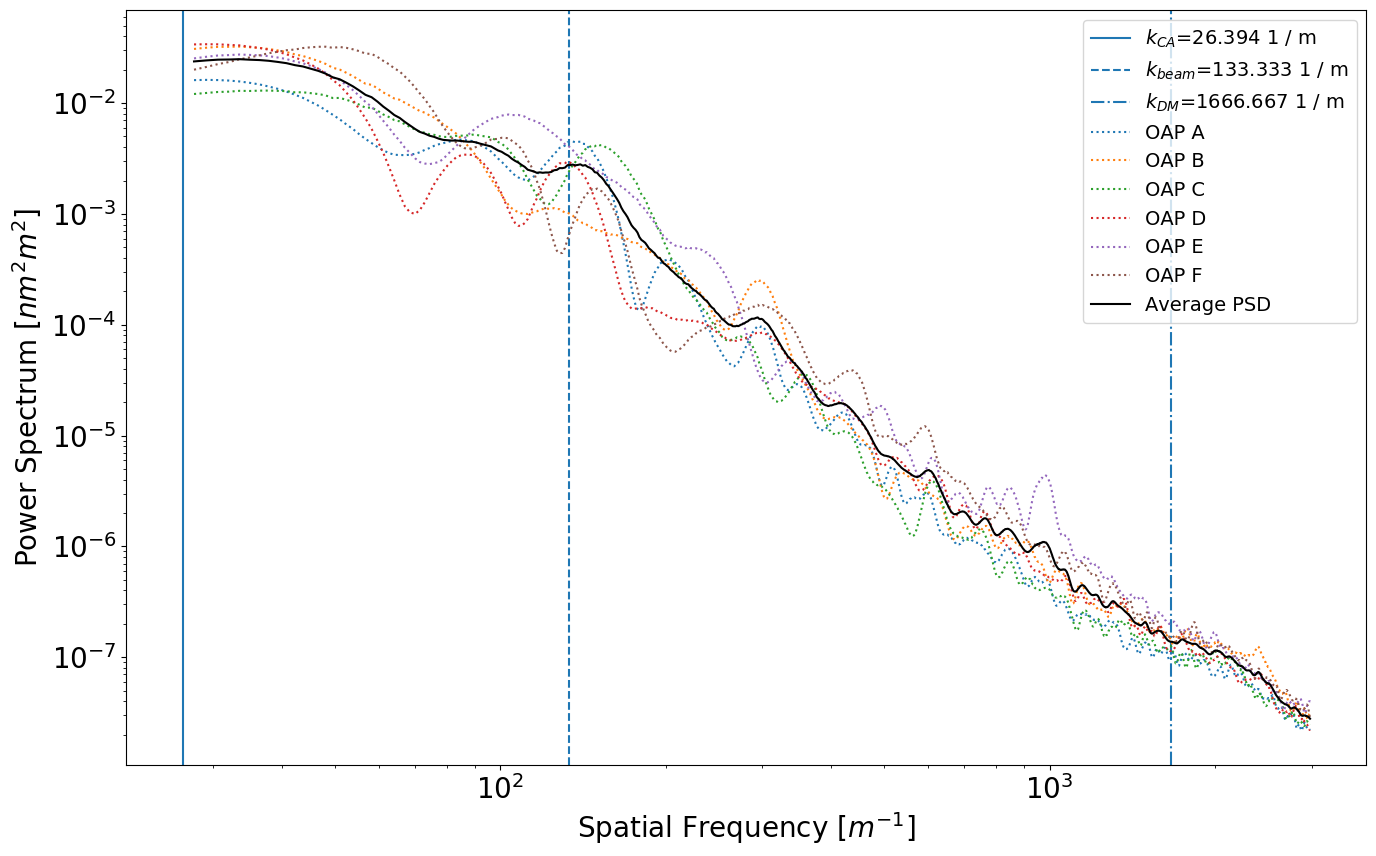

In [39]:
matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[16,10], dpi=100)

# draw vertical line for the tweeter bandwith
plt.axvline(x=oap[0].k_min.value, ls='-', label='{0}={1:.3f}'.format(r'$k_{CA}$', oap[0].k_min))
plt.axvline(x=bw_beam.value, ls='--', label='{0}={1:.3f}'.format(r'$k_{beam}$', bw_beam))
plt.axvline(x=bw_dm.value, ls='-.', label='{0}={1:.3f}'.format(r'$k_{DM}$', bw_dm))

n = 0
for obj in oap:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, ':', 
               label='{0}'.format(obj.surf_name))
    n = n+1
plt.loglog(avg_psd_k.value, avg_psd_radial.value, 'k', 
           label='Average PSD')#, RMS={0:.3f}'.format(avg_rms))


plt.xlabel('Spatial Frequency [{0}]'.format(oap[0].k_radial.unit))
#plt.ylabel('PSD [{0}]'.format(str(psd_units)))#oap[0].psd_radial_cal.unit))
plt.xlabel('Spatial Frequency [{0}]'.format(r'$m^{-1}$'))
plt.ylabel('Power Spectrum [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))
#plt.title('CACTI coated OAP PSD')
plt.legend(prop={'size':14})#,loc='center left', bbox_to_anchor=(1, 0.5))

## Saving the data
Everything is saved as a .fits file. The 2D PSD file is very easy and fast to calculate, so I recommend running the code to get that. But the 1D radial PSD is very slow to calculate, so I'm going to save them as .fits files for easy reference.

In [49]:
for j in range(0, len(oap)):
    hdr = fits.Header()
    hdr['name'] = oap[j].surf_name
    hdr['psd_unit'] = (str(oap[j].psd_cal.unit), 'units for PSD data')
    hdr['diam_ca'] = (oap[j].diam_ca.value, 
                      'physical diameter for clear aperture [{0}]'.format(oap[j].diam_ca.unit))
    hdr['latres'] = (oap[j].latres.value,
                     'Lateral resolution of data [{0}]'.format(oap[j].latres.unit))
    hdr['delta_k'] = (oap[j].delta_k.value,
                 'spatial frequency resolution at PSD [{0}]'.format(oap[j].delta_k.unit))
    hdr['rms_tot'] = (oap[j].rms_tot.value,
                      'total clear aperture rms [{0}]'.format(oap[j].rms_tot.unit))
    hdr['d_beam'] = (beam_diam.value,
                     'CACTI beam diameter [{0}]'.format(beam_diam.unit))
    hdr['bw_beam'] = (bw_beam.value,
                     'Spatial Frequency bandwidth [{0}]'.format(bw_beam.unit))
    hdr['rms_beam'] = (beam_rms[j], 
                       'CACTI beam diameter rms [nm]')
    hdr['n_act_dm'] = (n_act_diam,
                       'Number of actuators (y axis)')
    hdr['bw_dm'] = (bw_dm.value,
                     'Spatial Frequency bandwidth [{0}]'.format(bw_dm.unit))
    hdr['rms_dm'] = (dm_rms[j], 
                       'BMC 1K correction rms [nm]')
    hdr['oap_ang'] = (7.5, 
                      'OAP half angle [deg]')
    hdr['comment'] = 'All RMS values calculated using 2D PSD.'
    hdr['comment'] = 'First row is spatial freq [{0}]'.format(oap[j].k_radial.unit)
    hdr['comment'] = 'Second row is radial PSD units [{0}]'.format(oap[j].psd_radial_cal.unit)
    
    fits_data = np.zeros((2, len(oap[j].k_radial)))
    fits_data[0] = oap[j].k_radial.value
    fits_data[1] = oap[j].psd_radial_cal.value
    
    fits.writeto('radial/psd_radial_oap{0}.fits'.format(oap_labels[j]),
                 fits_data, hdr, overwrite=True)

In [52]:
j = 0
hdr = fits.Header()
hdr['name'] = 'Avg_OAP'
hdr['psd_unit'] = (str(oap[j].psd_cal.unit), 'units for PSD data')
hdr['diam_ca'] = (oap[j].diam_ca.value, 
                  'physical diameter for clear aperture [{0}]'.format(oap[j].diam_ca.unit))
hdr['latres'] = (oap[j].latres.value,
                 'Lateral resolution of data [{0}]'.format(oap[j].latres.unit))
hdr['delta_k'] = (oap[j].delta_k.value,
             'spatial frequency resolution at PSD [{0}]'.format(oap[j].delta_k.unit))
hdr['rms_tot'] = (avg_rms.value,
                  'total clear aperture rms [{0}]'.format(avg_rms.unit))
hdr['d_beam'] = (beam_diam.value,
                 'CACTI beam diameter [{0}]'.format(beam_diam.unit))
hdr['bw_beam'] = (bw_beam.value,
                 'Spatial Frequency bandwidth [{0}]'.format(bw_beam.unit))
hdr['rms_beam'] = (avg_beam_rms.value, 
                   'CACTI beam diameter rms [nm]')
hdr['n_act_dm'] = (n_act_diam,
                   'Number of actuators (y axis)')
hdr['bw_dm'] = (bw_dm.value,
                 'Spatial Frequency bandwidth [{0}]'.format(bw_dm.unit))
hdr['rms_dm'] = (avg_dm_rms.value, 
                   'BMC 1K correction rms [nm]')
hdr['comment'] = 'This is the average OAP PSD data.'
hdr['comment'] = 'All RMS values calculated using 2D PSD.'
hdr['comment'] = 'First row is spatial freq [{0}]'.format(avg_psd_k.unit)
hdr['comment'] = 'Second row is radial PSD units [{0}]'.format(avg_psd_radial.unit)

fits_data = np.zeros((2, len(oap[j].k_radial)))
fits_data[0] = avg_psd_k.value
fits_data[1] = avg_psd_radial.value

fits.writeto('radial/psd_radial_oapAVG.fits',
             fits_data, hdr, overwrite=True)